In [1]:
import numpy as np

In [2]:
# Heights of 6 people at the bar counter
d = np.array([179, 174, 182, 162, 175, 165])

# Average heights for males and females
mu_male = 181
mu_female = 165

# Smoothness penalty (referred to as β in the text)
smoothness_penalty = 10

# Calculate one-clique potentials (likelihood terms) for all persons and both labels
male_potentials = np.array([(mu_male - height)**2 for height in d])
female_potentials = np.array([(mu_female - height)**2 for height in d])

# Print potentials for verification (these should match the values in the text)
print("Male potentials:", male_potentials)    # Should be [4, 49, 1, 361, 36, 256]
print("Female potentials:", female_potentials)  # Should be [196, 81, 289, 9, 100, 0]


Male potentials: [  4  49   1 361  36 256]
Female potentials: [196  81 289   9 100   0]


In [3]:
# Function to calculate likelihood energy U(d|f) for a configuration

def likelihood_energy(config):
    "Calculate the likelihood energy for a given configuration of labels"
    energy = 0 
    for i, label in enumerate(config):
        if label =='M':
            energy += male_potentials[i]
        else: # label =='F'
            energy += female_potentials[i]
    return energy 

# Function to calculate prior energy U(f) for a configuration
def prior_energy(config):
    """Calculate the prior energy (smoothness term) for a given configuration"""
    energy = 0
    for i in range(len(config) - 1):
        if config[i] != config[i + 1]:
            energy += smoothness_penalty
    return energy

# Function to calculate posterior energy U(f|d) for a configuration
def posterior_energy(config):
    """Calculate the posterior energy (likelihood + prior) for a configuration"""
    return likelihood_energy(config) + prior_energy(config)



# Generate all possible configurations (2^6 = 64 total)
def generate_all_configurations(n=6):
    """Generate all possible M/F configurations for n people"""
    if n == 0:
        return [[]]
    smaller_configs = generate_all_configurations(n-1)
    return [config + ['M'] for config in smaller_configs] + [config + ['F'] for config in smaller_configs]



In [4]:
# Find optimal configuration by brute force (trying all configurations)
all_configs = generate_all_configurations()
best_config = None
min_energy = float('inf')

# Examine each possible configuration to find the one with minimum posterior energy
for config in all_configs:
    energy = posterior_energy(config)
    if energy < min_energy:
        min_energy = energy
        best_config = config

# Define the specific configurations mentioned in the text
# f_D is the configuration that minimizes likelihood energy only
f_D = ['M', 'M', 'M', 'F', 'M', 'F']  
# f_O is the configuration that minimizes posterior energy (optimal)
f_O = ['M', 'M', 'M', 'F', 'F', 'F']  

# Calculate and print energies for these specific configurations
print("\nData-only optimal configuration f_D:", f_D)
print("Likelihood energy U(d|f_D):", likelihood_energy(f_D))
print("Prior energy U(f_D):", prior_energy(f_D))
print("Posterior energy U(f_D|d):", posterior_energy(f_D))

print("\nOverall optimal configuration f_O:", f_O)
print("Likelihood energy U(d|f_O):", likelihood_energy(f_O))
print("Prior energy U(f_O):", prior_energy(f_O))
print("Posterior energy U(f_O|d):", posterior_energy(f_O))

print("\nVerified optimal configuration:", best_config)
print("With posterior energy:", min_energy)


Data-only optimal configuration f_D: ['M', 'M', 'M', 'F', 'M', 'F']
Likelihood energy U(d|f_D): 99
Prior energy U(f_D): 30
Posterior energy U(f_D|d): 129

Overall optimal configuration f_O: ['M', 'M', 'M', 'F', 'F', 'F']
Likelihood energy U(d|f_O): 163
Prior energy U(f_O): 10
Posterior energy U(f_O|d): 173

Verified optimal configuration: ['M', 'M', 'M', 'F', 'M', 'F']
With posterior energy: 129


In [5]:
import skimage.io
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from functions import *


In [6]:
def segmentation_energy(S, D, mu, beta):
    # Step 1: Compute intensity realization
    intensity_realization = np.zeros_like(D)
    for i in range(len(mu)):
        intensity_realization[S == i] = mu[i]
    
    # Step 2: Calculate likelihood energy (V1)
    V1 = np.sum((D - intensity_realization)**2)
    
    # Step 3: Calculate prior energy (V2)
    V2 = 0
    
    # Horizontal neighbors
    horizontal_diff = (S[:, :-1] != S[:, 1:])
    V2 += np.sum(horizontal_diff) * beta
    
    # Vertical neighbors
    vertical_diff = (S[:-1, :] != S[1:, :])
    V2 += np.sum(vertical_diff) * beta
    
    return V1, V2

def segmentation_histogram(ax, D, S, edges=None):
    '''
    Plot histogram for grayscale data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(D.min(), D.max(), 100)
    ax.hist(D.ravel(), bins=edges, color = 'k')
    centers = 0.5 * (edges[:-1] + edges[1:])
    for k in range(S.max() + 1):
        ax.plot(centers, np.histogram(D[S==k].ravel(), edges)[0])


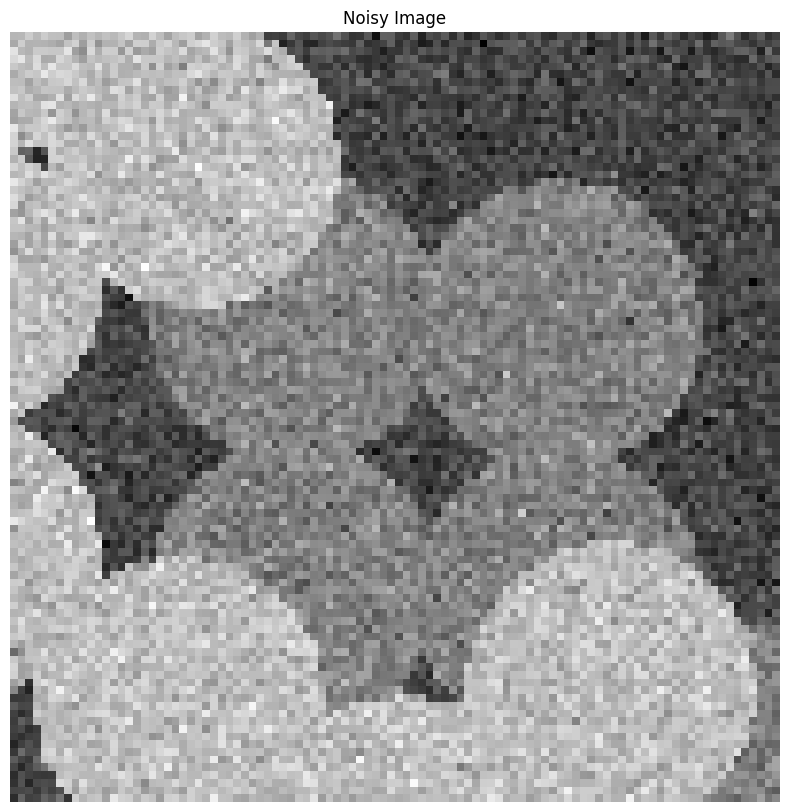

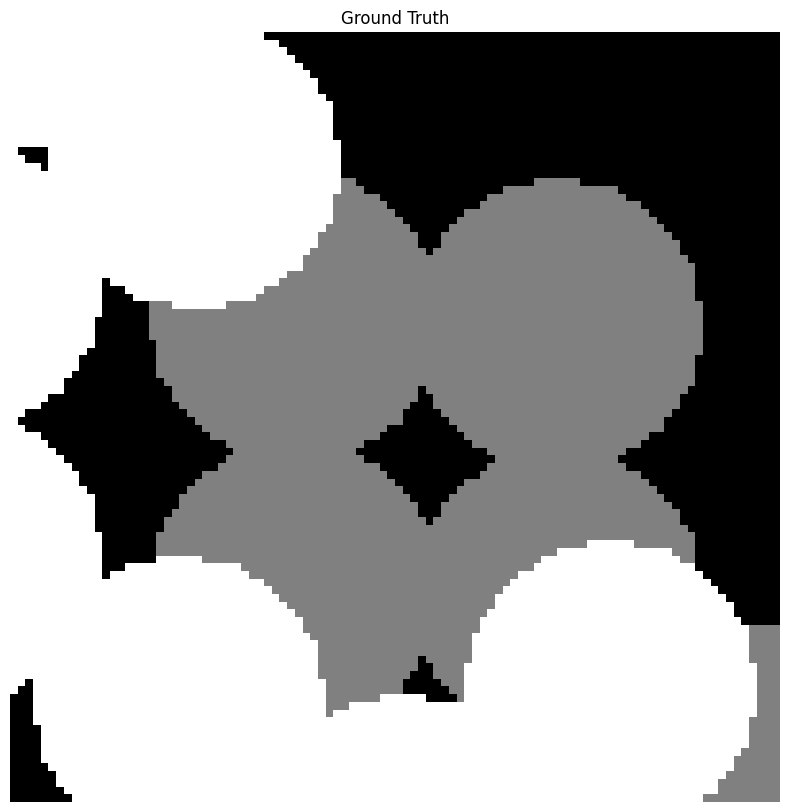

In [7]:
path = '../Chapter05/Data/'
D = skimage.io.imread(path + 'noisy_circles.png').astype(float)

# Ground truth 
GT = skimage.io.imread(path + 'noise_free_circles.png').astype(float)
(mu, S_gt) = np.unique(GT, return_inverse = True)
S_gt = S_gt.reshape(D.shape)


visualize_the_image(D, 'Noisy Image')
visualize_the_image(GT, 'Ground Truth')


[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 1 0]
 ...
 [0 0 0 ... 1 2 1]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 1]]


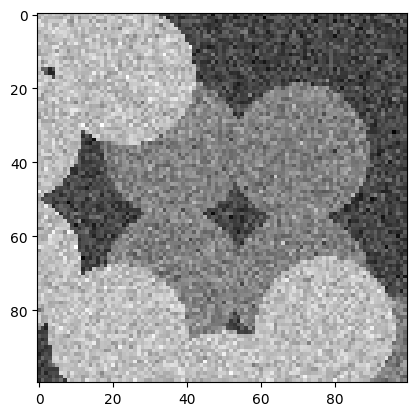

In [8]:
# Simple thresholding
S_t = np.zeros(D.shape, dtype=int) + (D > 100) + (D > 160) # thresholded
print(S_t)

# Gaussian filtering followed by thresholding
D_s = scipy.ndimage.gaussian_filter(D, sigma=1, truncate=3, mode='nearest')
S_g = np.zeros(D.shape, dtype=int) + (D_s > 100) + (D_s > 160) 

# Median filtering followed by thresholding
D_m = scipy.ndimage.median_filter(D, size=(5, 5), mode='reflect')
S_m = np.zeros(D.shape, dtype=int) + (D_m > 100) + (D_m > 160) # thresholded
#%% visualization
fig, ax = plt.subplots()
ax.imshow(D, vmin=0, vmax=255, cmap=plt.cm.gray)
plt.show()


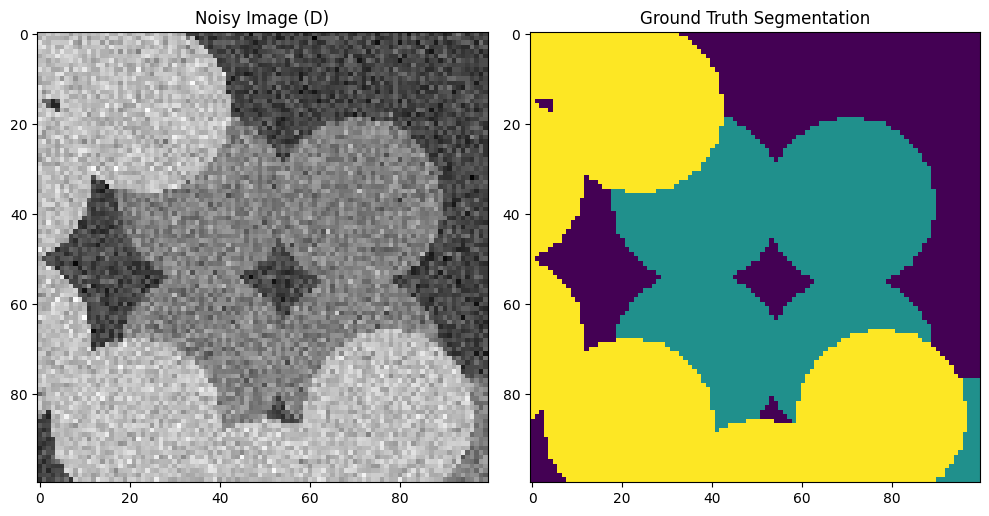

Mu [ 70. 130. 190.]
Likelihood: 3999.8k
Prior: 64.3k
Total: 4064.1k
Likelihood: 3041.7k
Prior: 372.0k
Total: 3413.7k
Likelihood: 4727.8k
Prior: 76.4k
Total: 4804.2k
Likelihood: 4798.9k
Prior: 65.8k
Total: 4864.7k


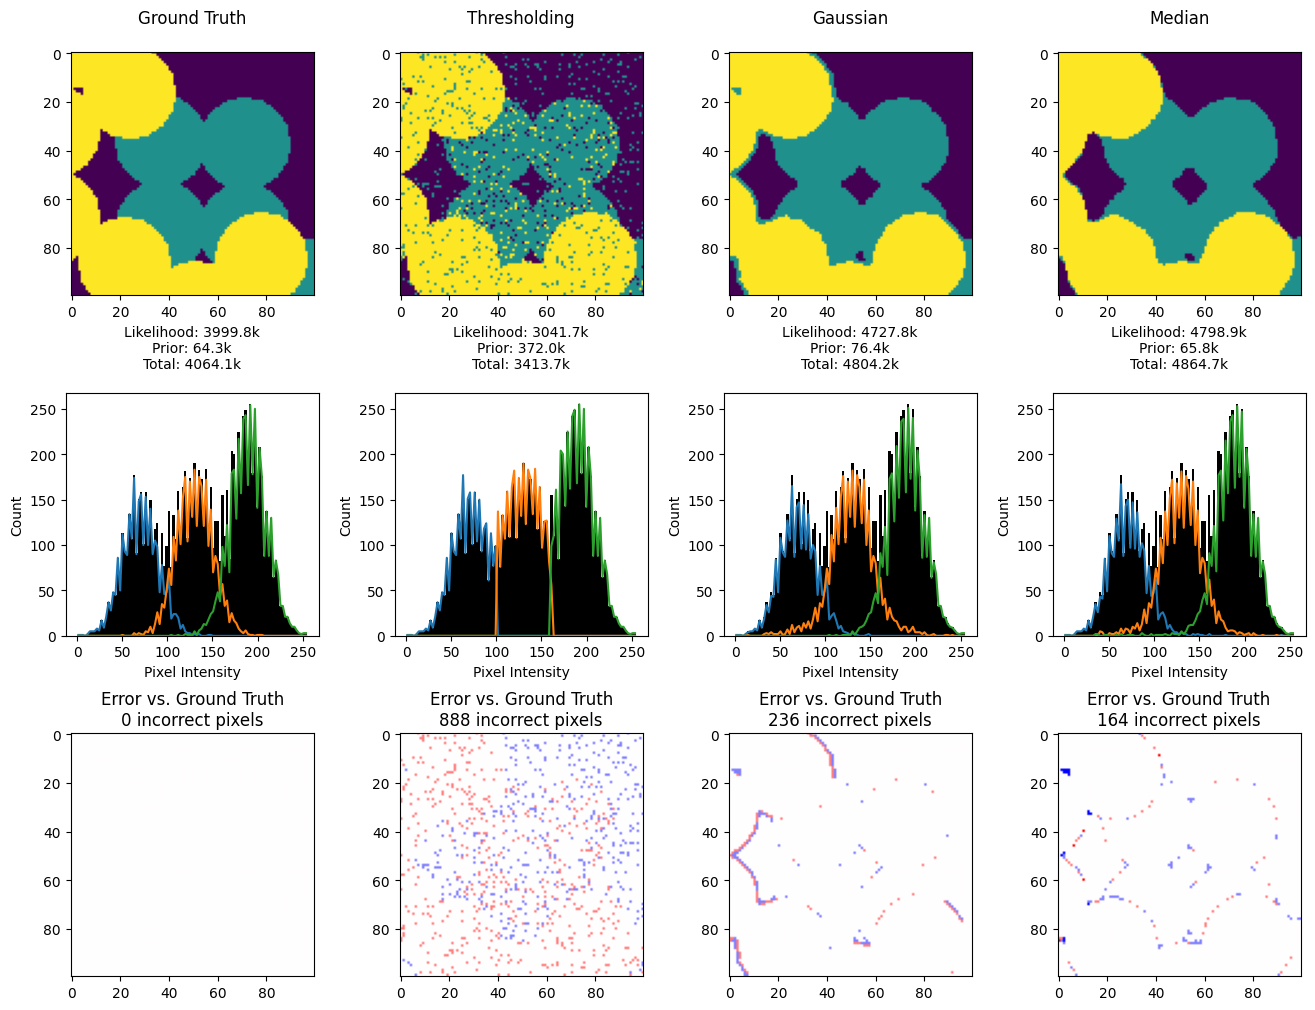

In [9]:
# First, display the original noisy image and ground truth
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(D, cmap='gray')
axes[0].set_title('Noisy Image (D)')
axes[1].imshow(S_gt, cmap='viridis')
axes[1].set_title('Ground Truth Segmentation')
plt.tight_layout()
plt.show()

beta = 100


# Now create a more detailed comparison of different segmentation methods
# This will show three rows of information for each segmentation method:
# 1. The actual segmentation
# 2. Histograms of pixel intensities for each segment
# 3. Error maps compared to ground truth

# Select just a few key segmentations to compare
selected_segmentations = [S_gt, S_t, S_g, S_m]  # Ground truth, thresholding, gaussian, median
method_names = ['Ground Truth', 'Thresholding', 'Gaussian', 'Median']

# Create a cleaner visualization
fig, ax = plt.subplots(3, len(selected_segmentations), figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add more space between subplots

print(f"Mu {mu}")


for i, s in enumerate(selected_segmentations):
    # Calculate energies
    V1, V2 = segmentation_energy(s, D, mu, beta)
    total = V1 + V2
    
    # Display segmentation with a cleaner title
    ax[0, i].imshow(s, cmap='viridis')
    ax[0, i].set_title(f'{method_names[i]}\n')
    
    # Add energy values as text below the image instead of in the title
    ax[0, i].text(0.5, -0.3, f'Likelihood: {V1/1000:.1f}k\nPrior: {V2/1000:.1f}k\nTotal: {total/1000:.1f}k', 
                 transform=ax[0, i].transAxes, ha='center', fontsize=10)
    
    print( f'Likelihood: {V1/1000:.1f}k\nPrior: {V2/1000:.1f}k\nTotal: {total/1000:.1f}k')
    
    # Plot histograms for each segment class
    segmentation_histogram(ax[1, i], D, s)
    ax[1, i].set_xlabel('Pixel Intensity')
    ax[1, i].set_ylabel('Count')
    
    # Show error map compared to ground truth
    error = S_gt - s
    ax[2, i].imshow(error, cmap='bwr', vmin=-2, vmax=2)
    error_count = np.sum(error != 0)
    ax[2, i].set_title(f'Error vs. Ground Truth\n{error_count} incorrect pixels')



#plt.tight_layout()
plt.savefig('segmentation_comparison.png', dpi=300)  # Optional: save the figure
plt.show()